In [1]:
import lightkurve as lk
from vetting import centroid_test

In [2]:
# from s0048-s0048:TCE1
tic, sector = 330795464, 48  # quite a few other sectors too
t0=2617.8403
duration=6.0456 / 24
period=16.968976

In [3]:
download_dir = "../../data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector)
tpf = sr.download(download_dir=download_dir)
tpf

TessTargetPixelFile(TICID: 330795464)

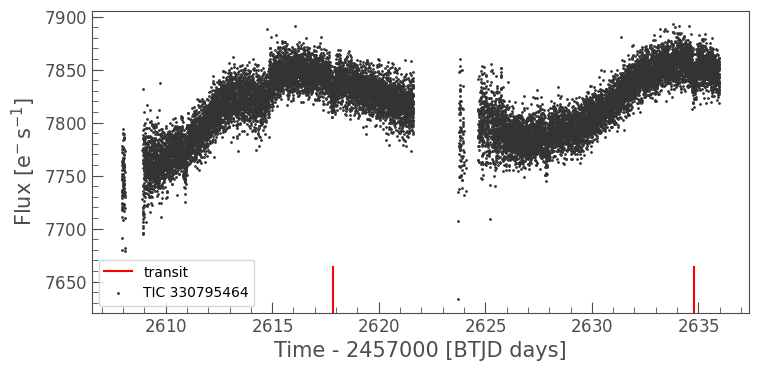

In [5]:
ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();
ax.axvline(t0 + period, c='red', ymax=0.15, label="transit");

{'figs': [<Figure size 288x288 with 1 Axes>],
 'pvalues': [(0.7086852445068572,)],
 'centroid_offset_detected': [array([False])]}

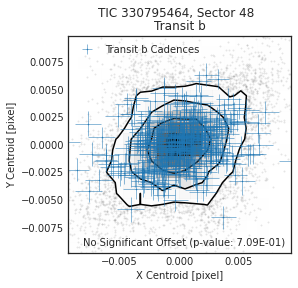

In [13]:
# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
# UNEXPECTED result: the test does not report signficant centroid shift, even though it is due to a NEB
r = centroid_test(tpf, period, t0, duration, aperture_mask='pipeline', plot=True);
r

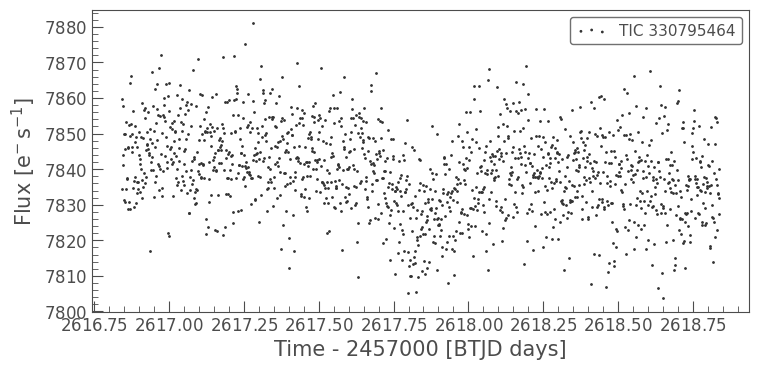

In [11]:
tpf_trunc = tpf[(t0 - 1 <= tpf.time.value) & (tpf.time.value <= t0 + 1)]
tpf_trunc.to_lightcurve().remove_outliers(sigma=7).scatter();

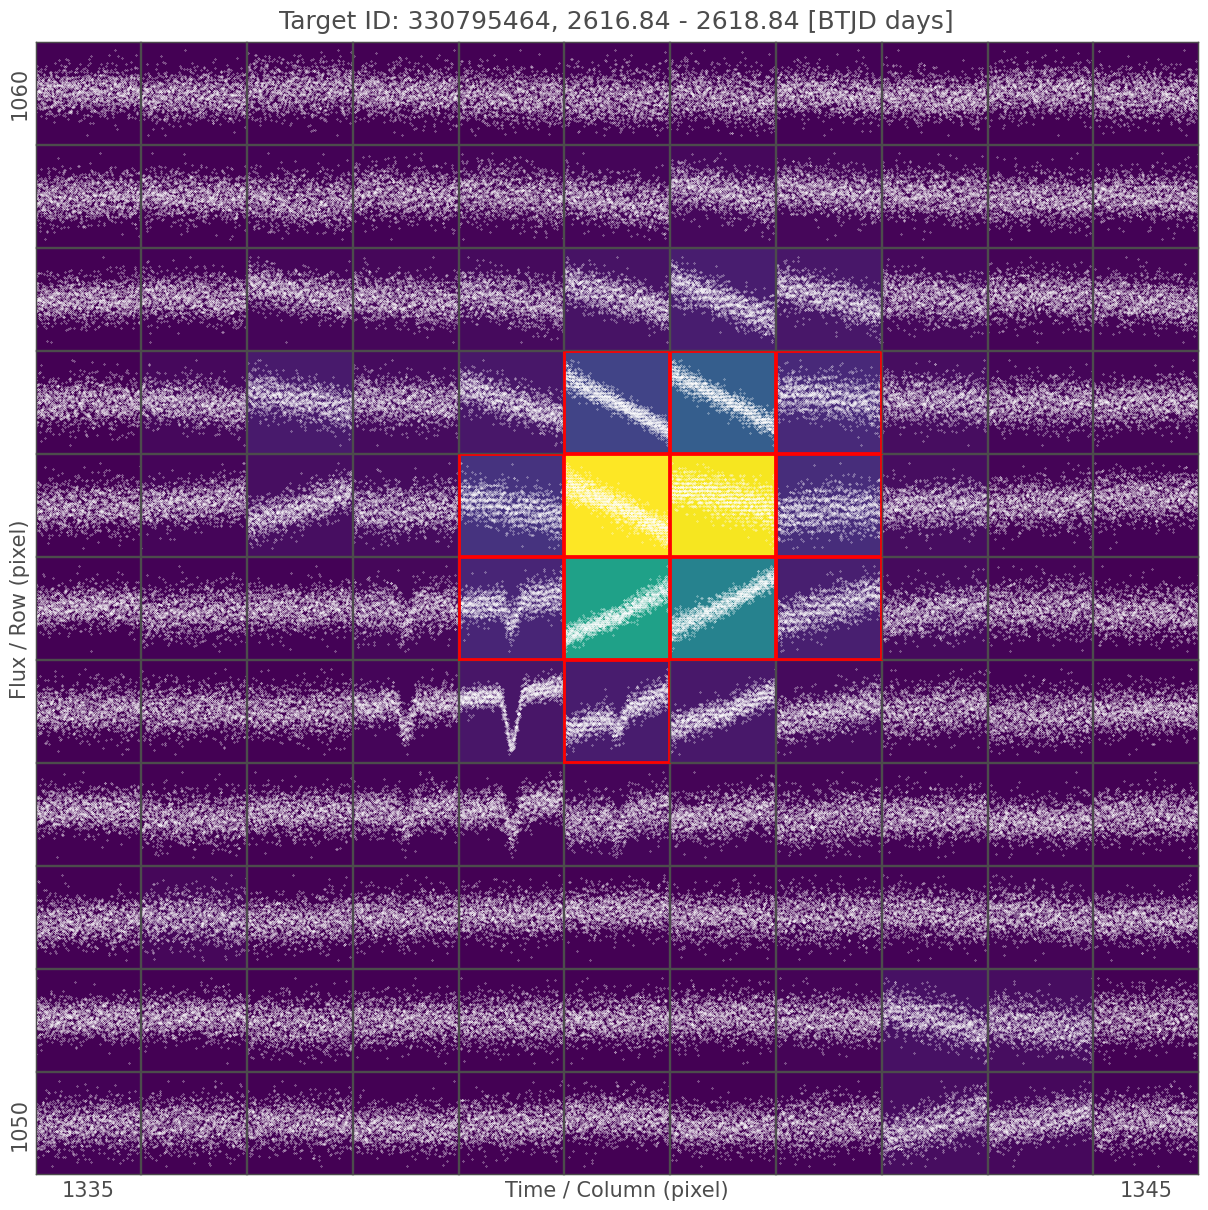

In [12]:
ax = tpf_trunc.plot_pixels(aperture_mask="pipeline", show_flux=True);